In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [3]:
#names_df = pd.read_csv("Resources/yob1978.txt", delimiter =",", names=["Name", "Gender", "YearOfBirth"],dtype={"Name":"str","Gender":"str", "YearOfBirth":np.int32})

start_year=1880
end_year=2019
yearlist= list(range(start_year,end_year,1))
#print(yearlist)
year_df=pd.DataFrame(yearlist)
year_df["dummy_col"]=1
year_df.set_index("dummy_col", inplace=True)
filename_list=[]
for file in os.listdir("names"):
    if file.endswith(".txt") and int(file[3:7]) >= start_year:
        df =  pd.read_csv("names/"+file, delimiter =",", names=["Name", "Gender", "CountOfNames"],dtype={"Name":"str","Gender":"str", "CountOfNames":np.int32})
        df["Year"] = int(file[3:7])
        
        df = df[["Year", "Name", "Gender", "CountOfNames"]]
        filename_list.append(df)
        
names_df = pd.concat(filename_list, axis=0, ignore_index=True)
names_df.sort_values(by=["Name","Gender","Year"], inplace=True)
unique_names_list = names_df.drop_duplicates(subset=["Name", "Gender"])[["Name", "Gender"]]
unique_names_list["dummy_col"]=1
unique_names_list.set_index("dummy_col", inplace=True)

final_data_set = unique_names_list.join(year_df,on="dummy_col",how = "outer")
final_data_set.rename(columns={0:"Year"}, inplace=True)

data_set_with_counts = final_data_set.merge(names_df, on=["Name", "Gender", "Year"], how = "outer")
data_set_with_counts.fillna(0, inplace = True)
data_set_with_counts["Percent_Change"] = data_set_with_counts["CountOfNames"].pct_change() * 100

In [4]:
baby_sum = names_df.groupby(['Gender','Year'])['CountOfNames'].sum()
baby_sum_df = pd.DataFrame(baby_sum)
baby_sum_df.rename(columns={'CountOfNames':'CountOfBabies'},inplace=True)
baby_sum_df.reset_index(inplace=True)
merged_df = pd.merge(data_set_with_counts,baby_sum_df, on=['Gender','Year'])

In [5]:
# name_sum = names_df.groupby(['Gender','Year'])['Name'].nunique()
# name_sum_df = pd.DataFrame(name_sum)
# name_sum_df.rename(columns={'Name':'CountUniqueNames'},inplace=True)
# name_sum_df.reset_index(inplace=True)
# merged_df2 = pd.merge(merged_df,name_sum_df, on=['Gender','Year'])

Count of unique names by gender:

In [6]:
names_df.groupby(['Gender'])['Name'].nunique()

Gender
F    67698
M    41475
Name: Name, dtype: int64

Count of names by gender:

In [7]:
names_df.groupby(['Gender'])['CountOfNames'].sum()

Gender
F    174079232
M    177573793
Name: CountOfNames, dtype: int32

Conclusion: There are more unique female names than male names

In [8]:
# create a data frame to pull begin the male/females analysis.

big_spikes_df = data_set_with_counts.loc[(data_set_with_counts["CountOfNames"]>100) 
                         & (data_set_with_counts["Percent_Change"]>50) 
                         & (data_set_with_counts["Year"]>1889) # to weed out 1880s, which are tainted by 1880 pct changes
                         & (data_set_with_counts["Year"]<2010)] # to weed out 2010s, which are an incomplete decade

# big_spikes_df = data_set_with_counts.loc[(data_set_with_counts["CountOfNames"]>100) 
#                          & (data_set_with_counts["Percent_Change"]>50) 
#                          & (data_set_with_counts["Year"]>1889) 
#                          & (data_set_with_counts["Year"]<2010) 
#                          & (data_set_with_counts["Percent_Change"]!=float('inf'))]

sorted_df = big_spikes_df.sort_values(['Percent_Change'],ascending = False)
sorted_df.count()

Name              6822
Gender            6822
Year              6822
CountOfNames      6822
Percent_Change    6822
dtype: int64

In [9]:
# bin the data by decades
labels = ["{0}s".format(decade) for decade in range(1880, 2020, 10)]
sorted_df['Decade'] = pd.cut(x = sorted_df['Year'], bins=np.arange(1880,2030,10), labels=labels,right = False)

In [10]:
# make the series to plot
raw_male = sorted_df.groupby(['Gender'])['Decade'].value_counts()['M'].sort_index()
raw_female = sorted_df.groupby(['Gender'])['Decade'].value_counts()['F'].sort_index()

In [11]:
# now bin the names_df to get a count of unique names by decade
names_df['Decade'] = pd.cut(x = names_df['Year'], bins=np.arange(1880,2030,10), labels=labels,right = False)
tot_male = names_df.groupby(['Gender'])['Decade'].value_counts()['M'].sort_index()
tot_female = names_df.groupby(['Gender'])['Decade'].value_counts()['F'].sort_index()

In [15]:
# control for the increased spikes due to more babies and names, generally
normal_df = pd.DataFrame({'TotalUniqueM':tot_male,
                          'TotalUniqueF':tot_female,
                         'SpikeM':raw_male,
                         'SpikeF':raw_female})
normal_df.drop(normal_df.index[0],inplace=True)
normal_df.drop(normal_df.index[-1],inplace=True)
normal_df

,TotalUniqueM,TotalUniqueF,SpikeM,SpikeF
1890s,12191,17331,11.0,25.0
1900s,14383,22292,73.0,53.0
1910s,36913,43600,472.0,206.0
1920s,48591,56771,33.0,65.0
1930s,41713,49777,48.0,160.0
1940s,40403,55239,123.0,351.0
1950s,43857,66667,141.0,365.0
1960s,46366,77810,137.0,336.0
1970s,62226,104971,204.0,550.0
1980s,77896,127928,230.0,711.0


In [16]:
male = 100*normal_df['SpikeM']/normal_df['TotalUniqueM']
female = 100*normal_df['SpikeF']/normal_df['TotalUniqueF']

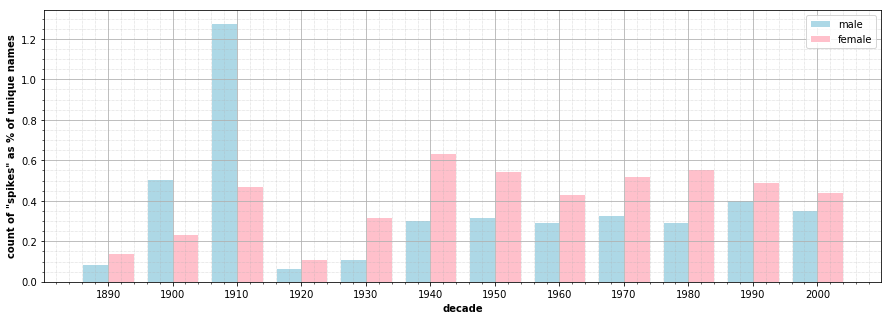

In [17]:
# set width of bar
plt.figure(figsize=[15,5])

barWidth = .4

# Set position of bar on X axis
r1 = np.arange(len(male))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, male, color='lightblue', width=barWidth, edgecolor='white', label='male')
plt.bar(r2, female, color='pink', width=barWidth, edgecolor='white', label='female')

# Add xticks on the middle of the group bars
plt.xlabel('decade', fontweight='bold')
plt.ylabel('count of "spikes" as % of unique names', fontweight='bold')
plt.minorticks_on()
plt.xticks((r1+r2)/2,np.arange(1890,2010,10))

# Create legend & Show graphic
plt.legend()
plt.grid(which = 'minor', linestyle = ':',linewidth = '0.5') # do something with this...
plt.grid(which = 'major', linestyle = '-')
plt.show()